In [1]:
import torch
import torch.nn as nn

In [ ]:
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

ticker_symbol = "SBUX"
df = yf.download(ticker_symbol, start="2010-01-01", end="2023-12-31")

df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
data = df['Close'].values.reshape(-1, 1)

[*********************100%***********************]  1 of 1 completed


In [9]:
data.shape

(3522, 1)

In [42]:
train_size = int(len(data) * 0.9)

trainset = data[:train_size]
testset = data[train_size:]

In [43]:
scaler = MinMaxScaler()
scaler.fit(trainset)
trainset_scaled = scaler.transform(trainset)
testset_scaled = scaler.transform(testset)

In [45]:
import numpy as np

def split_dataset(data, seq_len):
  X, y  = [], []
  for i in range(len(data)-(seq_len)):
    X.append(data[i:i+seq_len, :]) 
    y.append(data[i+seq_len])
  return np.array(X), np.array(y)

In [46]:
X_train, y_train = split_dataset(trainset_scaled, 30)
X_test, y_test = split_dataset(testset_scaled, 30)

In [47]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3139, 30, 1), (3139, 1), (323, 30, 1), (323, 1))

In [48]:
X_train_tensor, y_train_tensor = torch.tensor(X_train).float(), torch.tensor(y_train).float()
X_test_tensor, y_test_tensor = torch.tensor(X_test).float(), torch.tensor(y_test).float()

In [49]:
from torch.utils.data import DataLoader, TensorDataset

loader_train = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), 
                                           batch_size=32)
loader_test = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), 
                                          batch_size=32)

In [50]:
class StockPrediction(nn.Module):
  def __init__(self, input_size=1, hidden_size=50, output_size=1):
    super(StockPrediction, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.linear = nn.Linear(hidden_size, output_size)


  def forward(self, x):
    out, (h, c) = self.lstm(x)
    out = self.linear(out[:, -1, :])
    return out

In [51]:
model = StockPrediction()

In [52]:
import torch.optim as optim

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [53]:
num_epochs = 200
# model.to(device)
model.train()
for epoch in range(num_epochs):
  total_loss = 0
  for X_batch, y_batch in loader_train:
    # X, y = X.to(device), y.to(device)
    out = model(X_batch)
    loss = loss_fn(out, y_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
  epoch_loss = total_loss / len(loader_train)
  print(f'epoch: {epoch+1}, loss: {epoch_loss}')

epoch: 1, loss: 0.011263807632172811
epoch: 2, loss: 0.03109313776407031
epoch: 3, loss: 0.04128311150327705
epoch: 4, loss: 0.04697837370710631
epoch: 5, loss: 0.034977216147990015
epoch: 6, loss: 0.017979172677484594
epoch: 7, loss: 0.006881240191598243
epoch: 8, loss: 0.0030863042398649294
epoch: 9, loss: 0.0012296844235257741
epoch: 10, loss: 0.0006463779167498073
epoch: 11, loss: 0.00048370867686268565
epoch: 12, loss: 0.0004506075657592752
epoch: 13, loss: 0.0004621082102260911
epoch: 14, loss: 0.0004884584675414542
epoch: 15, loss: 0.0005191897453738475
epoch: 16, loss: 0.0005503164884935864
epoch: 17, loss: 0.0005800334527870144
epoch: 18, loss: 0.0006073861297106001
epoch: 19, loss: 0.0006318476836730207
epoch: 20, loss: 0.0006531630538625501
epoch: 21, loss: 0.0006712711328597807
epoch: 22, loss: 0.0006862481329859072
epoch: 23, loss: 0.000698262916043262
epoch: 24, loss: 0.0007075439593515484
epoch: 25, loss: 0.0007143479068036693
epoch: 26, loss: 0.0007189407167768675
epoch

In [54]:
model.eval()

y_pred_list = []
with torch.no_grad():
  for X_batch, _ in loader_test:
    y_pred = model(X_batch).numpy()
    #y_pred = model(X_batch).cpu().numpy()
    y_pred_list.append(y_pred)

y_pred = np.concatenate(y_pred_list, axis=0)

In [55]:
y_pred.shape

(323, 1)

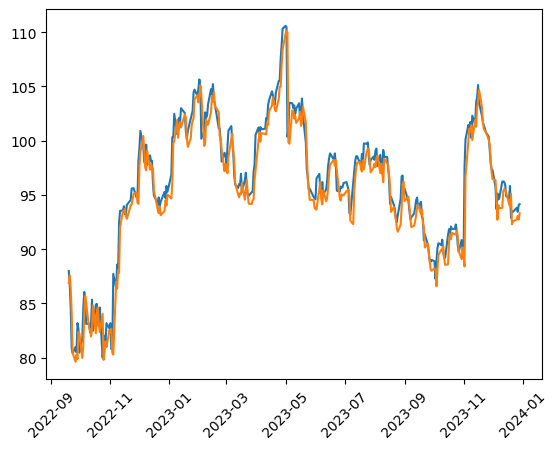

In [56]:
import matplotlib.pyplot as plt

y_test_ori = scaler.inverse_transform(y_test)
y_pred_ori = scaler.inverse_transform(y_pred)

plt.xticks(rotation=45)
plt.plot(df.index[train_size + seq_len:], y_test_ori)
plt.plot(df.index[train_size + seq_len:], y_pred_ori)

In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_ori, y_pred_ori)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_ori, y_pred_ori)
r2 = r2_score(y_test_ori, y_pred_ori)

print(f"MSE: {mse:.5f}, RMSE: {rmse:.5f}, MAE: {mae:.5f}, R2: {r2:.5f}")

MSE: 2.71080, RMSE: 1.64645, MAE: 1.17943, R2: 0.92951
